In [1]:
%load_ext autoreload
%autoreload 2


%pylab inline

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms

import numpy as np
import tqdm
import torch

from models import VAE

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
BS = 64
dataset = torchvision.datasets.MNIST(root='.', download=True,
                     transform=transforms.Compose([
                     transforms.ToTensor(),
                     transforms.Normalize((0.5,), (0.5,))
                     ]))

# Dataloader
dataloader = DataLoader(dataset, batch_size=BS,
                                         shuffle=True, num_workers=2)

In [3]:
img_size = dataloader.dataset[0][0].shape[1]
latent_dim = 8
hidden_dim = 128

lr = 0.0002
kl_weight = 0.00001

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'



In [4]:
model = VAE(img_size=img_size, hidden_dim=hidden_dim, latent_dim=latent_dim)
model.to(device)

optim = torch.optim.AdamW(model.parameters(), lr = lr)


In [5]:
def loss_function(x, x_pred, mu, logvar, kl_weight = 1, criterion = torch.nn.MSELoss()):
    loss = criterion(x_pred, x) - kl_weight * 0.5 * torch.mean(1-torch.exp(logvar) - mu**2 + logvar)
    
    return loss

In [6]:
losses = []

epochs = 20
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    for batch,_ in pbar: 
        x = batch.view(batch.shape[0],-1).to(device)
        x_hat, mu, logvar = model(x)

        optim.zero_grad()

        loss = loss_function(x,x_hat, mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optim.step()

        losses.append(loss.item())
        pbar.set_description(f'Loss: %.3f' % loss.item())




Loss: 0.082: 100%|██████████| 938/938 [00:12<00:00, 76.55it/s] 


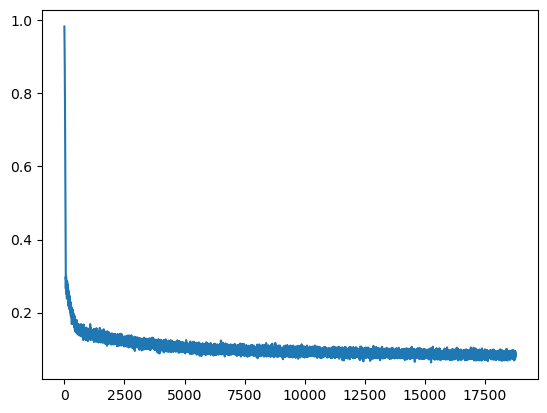

In [7]:
plot(losses)

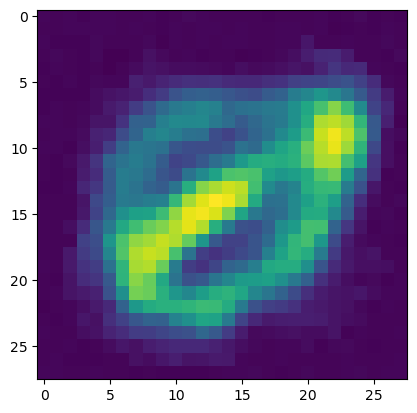

In [49]:
x = torch.randn(1,8).float().to(device)
model.eval()
with torch.no_grad():
    recon = model.decoder(x)
    recon = (recon +1)/2

imshow(recon.cpu().numpy().reshape(img_size,img_size))

# VAE convolutionnal architecture

In [69]:
from models import VAE_3D
import yaml

with open('./VAE_parameters.yaml', 'rb') as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        print(exc)
    
model2d = VAE_3D(config['model parameters'])
model2d.to(device)


VAE_3D(
  (enc_convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
  )
  (mlp_mu): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=576, out_features=128, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=2, bias=True)
      (1): LeakyReLU(negative_slope=0.01)
    )
  )
  (mlp_

In [70]:
model2d.dec_kernels, model2d.output_pad, model2d.pad, model2d.nb_classes

([2, 2, 2], [1, 0, 0], [0, 0, 0], 10)

In [71]:

lr2d = 0.005
kl_weight = 0.00001
optimizer = torch.optim.AdamW(model2d.parameters(), lr = lr2d)
epochs = 10


In [72]:
losses2d = []

model2d.train()
for _ in range(epochs):
    pbar = tqdm.tqdm(dataloader)
    losses_epoch = []
    for batch, labels in pbar: 
        labels = labels.long().to(device)
        x = batch.float().to(device)
        x_hat, mu, logvar = model2d(x, labels)

        optimizer.zero_grad()

        loss = loss_function(x,x_hat, mu, logvar, kl_weight=kl_weight)
        loss.backward()
        optimizer.step()

        losses_epoch.append(loss.item())

        pbar.set_description(f'Loss: %.3f' % loss.item())
    
    mean_loss = mean(losses_epoch)
    losses2d.extend(losses_epoch)



Loss: 0.193: 100%|██████████| 938/938 [00:15<00:00, 62.30it/s]


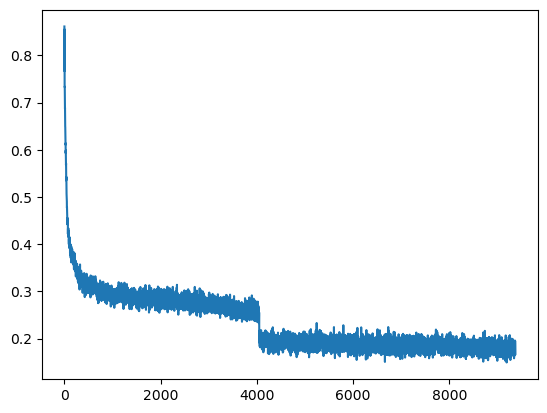

In [73]:
plot(losses2d[10:])

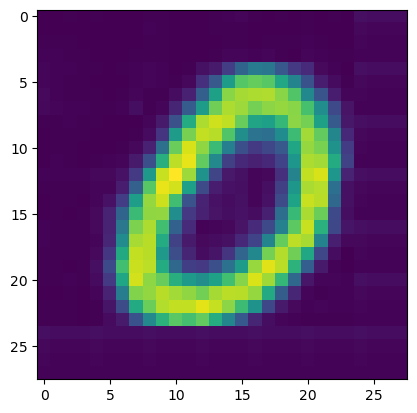

In [79]:
model2d.eval()
with torch.no_grad():
    if model2d.conditionnal:
        for l in range(10):
            gen_img = (model2d.sample(1).cpu()[0]+1)/2
            imshow(gen_img.permute(1,2,0))
            show()
    else:
        gen_img = (model2d.sample(1).cpu()[0]+1)/2
        imshow(gen_img.permute(1,2,0))

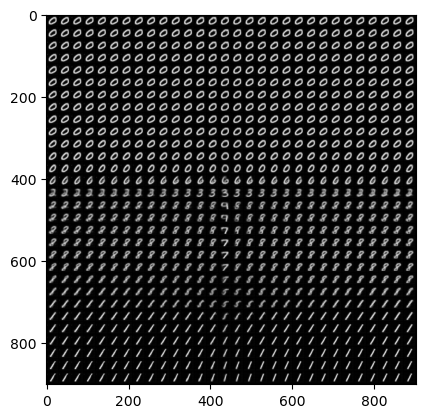

In [77]:
if model2d.latent_dim==2:
    grid = model2d.eval_manifold()

    if model2d.conditionnal:
        for g in grid:
            imshow(g.permute(1,2,0))
            show()
    else:
        imshow(grid.permute(1,2,0))